In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Data_Assignment4.zip -d /content/dataset

Archive:  /content/drive/MyDrive/Data_Assignment4.zip
   creating: /content/dataset/Data_Assignment4/
   creating: /content/dataset/Data_Assignment4/Data:Assignment4/
   creating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ba.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/bhA.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ka.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ni.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/tA.zip  
   creating: /content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data/
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data/a.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data/ai.zip  
  inflating: /content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data/bA.zip  

## **Loading and preprocessing data**

In [145]:
import os
import numpy as np
import pandas as pd
import torch
import zipfile

def load_zip_data(zip_path, type):
    data = []
    labels = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        for file_name in z.namelist():
            if type == "Train":
              if file_name.split('/')[1] != 'train':
                continue
            elif type == "Test":
              if file_name.split('/')[1] != 'dev':
                continue
            with z.open(file_name) as f:
                points = list(map(float, f.read().decode().split()))
                num_points = int(points[0])
                x_coords = points[1::2]
                y_coords = points[2::2]
                normalized_x = (np.array(x_coords) - min(x_coords)) / (max(x_coords) - min(x_coords))
                normalized_y = (np.array(y_coords) - min(y_coords)) / (max(y_coords) - min(y_coords))
                data.append(np.column_stack((normalized_x, normalized_y)))
                labels.append(zip_path.split('/')[-1].split('.')[0])  # Use zip name as label

    return data, labels

# Load data from the Hand_writing_Data directory
handwriting_data_train = []
handwriting_labels_train = []
handwriting_data_test = []
handwriting_labels_test = []
handwriting_data_path = '/content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data'

for zip_file in os.listdir(handwriting_data_path):
    if zip_file.endswith('.zip'):
        data, labels = load_zip_data(os.path.join(handwriting_data_path, zip_file), "Train")
        data_test, labels_test = load_zip_data(os.path.join(handwriting_data_path, zip_file), "Test")
        handwriting_data_train.extend(data)
        handwriting_labels_train.extend(labels)
        handwriting_data_test.extend(data_test)
        handwriting_labels_test.extend(labels_test)

In [146]:
# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## **Shuffle the data for both training and testing**

In [147]:
import random

combined_train_data = list(zip(handwriting_data_train, handwriting_labels_train))
random.shuffle(combined_train_data)

handwriting_data_train_shuf, handwriting_labels_train_shuf = zip(*combined_train_data)
handwriting_data_train_shuf = list(handwriting_data_train_shuf)
handwriting_labels_train_shuf = list(handwriting_labels_train_shuf)

combined_test_data = list(zip(handwriting_data_test, handwriting_labels_test))
random.shuffle(combined_test_data)

handwriting_data_test_shuf, handwriting_labels_test_shuf = zip(*combined_test_data)
handwriting_data_test_shuf = list(handwriting_data_test_shuf)
handwriting_labels_test_shuf = list(handwriting_labels_test_shuf)

In [148]:
from torch.nn.utils.rnn import pad_sequence

# Convert labels to numerical
label_to_idx = {label: idx for idx, label in enumerate(set(handwriting_labels_train_shuf))}
numeric_labels = [label_to_idx[label] for label in handwriting_labels_train_shuf]

# Convert to PyTorch tensors
handwriting_data = pad_sequence([torch.tensor(sample, dtype=torch.float32) for sample in handwriting_data_train_shuf]).permute(1, 0, 2).to(device)
numeric_labels = torch.tensor(numeric_labels, dtype=torch.long).to(device)

# Check the lengths of the data and labels
print(f"Loaded {len(handwriting_data)} samples with {len(numeric_labels)} labels.")

Loaded 345 samples with 345 labels.


In [149]:
# Convert labels to numerical
label_to_idx_test = {label: idx for idx, label in enumerate(set(handwriting_labels_test_shuf))}
numeric_labels_test = [label_to_idx[label] for label in handwriting_labels_test_shuf]

# Convert to PyTorch tensors
handwriting_data_test_shuf = pad_sequence([torch.tensor(sample, dtype=torch.float32) for sample in handwriting_data_test_shuf]).permute(1, 0, 2).to(device)
numeric_labels_test = torch.tensor(numeric_labels_test, dtype=torch.long).to(device)

# Check the lengths of the data and labels
print(f"Loaded {len(handwriting_data_test_shuf)} samples with {len(numeric_labels_test)} labels.")

Loaded 100 samples with 100 labels.


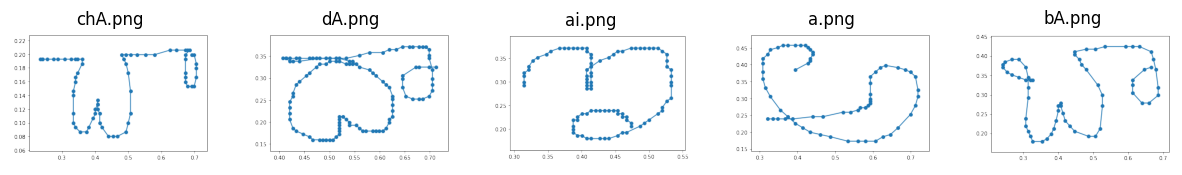

In [150]:
from PIL import Image
import matplotlib.pyplot as plt

sample_images_path = '/content/dataset/Data_Assignment4/Data:Assignment4/Hand_writing_Data/_Sample-Image-for-each-class'

sample_images = {}
for img_name in os.listdir(sample_images_path):
    img_path = os.path.join(sample_images_path, img_name)
    img = Image.open(img_path)
    sample_images[img_name] = img

# Display sample images
fig, axs = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, (name, img) in zip(axs, sample_images.items()):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis('off')
plt.show()


In [151]:
def train_model_with_accuracy(model, data, labels, num_epochs=1000, learning_rate=0.01, threshold = 1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    accuracies = []
    epoch_losses = []
    prev_epoch_loss = float('inf')
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_losses.append(epoch_loss)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        accuracies.append(accuracy)

        # # Early stopping criteria
        # if abs(prev_epoch_loss - epoch_loss) < threshold:
        #     print(f"Convergence reached at epoch {epoch + 1}")
        #     break

        prev_epoch_loss = epoch_loss
        # Print loss and accuracy every 10 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

    return epoch_losses, accuracies, model

In [152]:
def evaluate_model(model, data, labels):
    model.eval()
    # Load the saved model state dict
    with torch.no_grad():
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
    return accuracy

## **RNN**

In [153]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Output of the last time step
        return out

# Model hyperparameters
input_size = 2  # Number of features (x and y coordinates)
hidden_size = [8, 16, 32]  # Number of LSTM units
num_layers = [1, 2, 3]  # Number of LSTM layers
output_size = len(label_to_idx)  # Number of classes

In [154]:
# Train the model with accuracy reporting
Modtab = pd.DataFrame(columns=['Type', 'Hidden Size', 'Number of Layers', 'Training Loss', 'Training Accuracy', 'Testing Accuracy', 'Model'])
for lay in num_layers:
    for hid in hidden_size:
        print(f'\nTraining RNN model with {hid} hidden units and {lay} layers')
        RNNmodel = RNNModel(input_size, hid, lay, output_size).to(device)
        epoch_losses, accuracies, model = train_model_with_accuracy(RNNmodel, handwriting_data, numeric_labels)
        train_acc = evaluate_model(RNNmodel, handwriting_data, numeric_labels)
        test_acc = evaluate_model(RNNmodel, handwriting_data_test_shuf, numeric_labels_test)
        Modtab.loc[len(Modtab)] = ['RNN', hid, lay, epoch_losses, train_acc, test_acc, model]


Training RNN model with 8 hidden units and 1 layers
Epoch [50/1000], Loss: 1.6073, Accuracy: 0.2058
Epoch [100/1000], Loss: 1.6053, Accuracy: 0.2058
Epoch [150/1000], Loss: 1.6048, Accuracy: 0.2058
Epoch [200/1000], Loss: 1.6047, Accuracy: 0.2087
Epoch [250/1000], Loss: 1.6048, Accuracy: 0.2058
Epoch [300/1000], Loss: 1.6047, Accuracy: 0.2058
Epoch [350/1000], Loss: 1.6047, Accuracy: 0.2000
Epoch [400/1000], Loss: 1.6047, Accuracy: 0.2058
Epoch [450/1000], Loss: 1.6047, Accuracy: 0.2058
Epoch [500/1000], Loss: 1.6047, Accuracy: 0.2087
Epoch [550/1000], Loss: 1.6047, Accuracy: 0.2087
Epoch [600/1000], Loss: 1.6046, Accuracy: 0.2058
Epoch [650/1000], Loss: 1.6047, Accuracy: 0.2058
Epoch [700/1000], Loss: 1.6047, Accuracy: 0.2058
Epoch [750/1000], Loss: 1.6046, Accuracy: 0.2087
Epoch [800/1000], Loss: 1.6046, Accuracy: 0.2116
Epoch [850/1000], Loss: 1.6046, Accuracy: 0.2116
Epoch [900/1000], Loss: 1.6046, Accuracy: 0.2116
Epoch [950/1000], Loss: 1.6046, Accuracy: 0.2116
Epoch [1000/1000]

## **LSTM**

In [155]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the output of the last layer
        return out

In [156]:
for lay in num_layers:
    for hid in hidden_size:
        print(f'\nTraining LSTM model with {hid} hidden units and {lay} layers')
        LSTMmodel = LSTMModel(input_size, hid, lay, output_size).to(device)
        epoch_losses, accuracies, model = train_model_with_accuracy(LSTMmodel, handwriting_data, numeric_labels)
        train_acc = evaluate_model(LSTMmodel, handwriting_data, numeric_labels)
        test_acc = evaluate_model(LSTMmodel, handwriting_data_test_shuf, numeric_labels_test)
        Modtab.loc[len(Modtab)] = ['LSTM', hid, lay, epoch_losses, train_acc, test_acc, model]


Training LSTM model with 8 hidden units and 1 layers
Epoch [50/1000], Loss: 1.6076, Accuracy: 0.2058
Epoch [100/1000], Loss: 1.6047, Accuracy: 0.2029
Epoch [150/1000], Loss: 1.5784, Accuracy: 0.2232
Epoch [200/1000], Loss: 1.5761, Accuracy: 0.2261
Epoch [250/1000], Loss: 1.5597, Accuracy: 0.2290
Epoch [300/1000], Loss: 1.5543, Accuracy: 0.2377
Epoch [350/1000], Loss: 1.5440, Accuracy: 0.2435
Epoch [400/1000], Loss: 1.5346, Accuracy: 0.2696
Epoch [450/1000], Loss: 1.5305, Accuracy: 0.2348
Epoch [500/1000], Loss: 1.5311, Accuracy: 0.2609
Epoch [550/1000], Loss: 1.5049, Accuracy: 0.2841
Epoch [600/1000], Loss: 1.4748, Accuracy: 0.2986
Epoch [650/1000], Loss: 1.4863, Accuracy: 0.3159
Epoch [700/1000], Loss: 1.7103, Accuracy: 0.2406
Epoch [750/1000], Loss: 1.5250, Accuracy: 0.2464
Epoch [800/1000], Loss: 1.5762, Accuracy: 0.2232
Epoch [850/1000], Loss: 1.5640, Accuracy: 0.2261
Epoch [900/1000], Loss: 1.5618, Accuracy: 0.2232
Epoch [950/1000], Loss: 1.5599, Accuracy: 0.2290
Epoch [1000/1000

## **GRU**

In [157]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Output of the last time step
        return out

In [158]:
for lay in num_layers:
    for hid in hidden_size:
        print(f'\nTraining GRU model with {hid} hidden units and {lay} layers')
        GRUmodel = GRUModel(input_size, hid, lay, output_size).to(device)
        epoch_losses, accuracies, model = train_model_with_accuracy(GRUmodel, handwriting_data, numeric_labels)
        train_acc = evaluate_model(GRUmodel, handwriting_data, numeric_labels)
        test_acc = evaluate_model(GRUmodel, handwriting_data_test_shuf, numeric_labels_test)
        Modtab.loc[len(Modtab)] = ['GRU', hid, lay, epoch_losses, train_acc, test_acc, model]


Training GRU model with 8 hidden units and 1 layers
Epoch [50/1000], Loss: 1.6073, Accuracy: 0.2058
Epoch [100/1000], Loss: 0.9502, Accuracy: 0.4058
Epoch [150/1000], Loss: 0.9449, Accuracy: 0.4116
Epoch [200/1000], Loss: 0.9364, Accuracy: 0.4290
Epoch [250/1000], Loss: 0.9328, Accuracy: 0.4493
Epoch [300/1000], Loss: 0.9256, Accuracy: 0.4696
Epoch [350/1000], Loss: 0.9075, Accuracy: 0.4899
Epoch [400/1000], Loss: 0.8463, Accuracy: 0.5159
Epoch [450/1000], Loss: 0.7592, Accuracy: 0.5623
Epoch [500/1000], Loss: 0.6756, Accuracy: 0.6087
Epoch [550/1000], Loss: 0.6642, Accuracy: 0.6203
Epoch [600/1000], Loss: 2.9414, Accuracy: 0.1971
Epoch [650/1000], Loss: 1.5505, Accuracy: 0.2435
Epoch [700/1000], Loss: 1.1698, Accuracy: 0.4493
Epoch [750/1000], Loss: 0.9223, Accuracy: 0.5275
Epoch [800/1000], Loss: 0.8934, Accuracy: 0.5623
Epoch [850/1000], Loss: 0.8651, Accuracy: 0.5739
Epoch [900/1000], Loss: 0.8362, Accuracy: 0.5768
Epoch [950/1000], Loss: 0.7991, Accuracy: 0.5797
Epoch [1000/1000]

In [159]:
Modtab

,Type,Hidden Size,Number of Layers,Training Loss,Training Accuracy,Testing Accuracy,Model
0,RNN,8,1,"[1.6276911497116089, 1.621170163154602, 1.6166...",0.211594,0.20,"RNNModel(\n (rnn): RNN(2, 8, batch_first=True..."
1,RNN,16,1,"[1.6202661991119385, 1.6116267442703247, 1.610...",0.205797,0.18,"RNNModel(\n (rnn): RNN(2, 16, batch_first=Tru..."
2,RNN,32,1,"[1.6208336353302002, 1.6101751327514648, 1.610...",0.205797,0.21,"RNNModel(\n (rnn): RNN(2, 32, batch_first=Tru..."
3,RNN,8,2,"[1.6496987342834473, 1.6359282732009888, 1.625...",0.205797,0.20,"RNNModel(\n (rnn): RNN(2, 8, num_layers=2, ba..."
4,RNN,16,2,"[1.6374704837799072, 1.6165450811386108, 1.609...",0.426087,0.18,"RNNModel(\n (rnn): RNN(2, 16, num_layers=2, b..."
5,RNN,32,2,"[1.6197192668914795, 1.6208171844482422, 1.612...",0.205797,0.20,"RNNModel(\n (rnn): RNN(2, 32, num_layers=2, b..."
6,RNN,8,3,"[1.6504594087600708, 1.6222611665725708, 1.614...",0.208696,0.20,"RNNModel(\n (rnn): RNN(2, 8, num_layers=3, ba..."
7,RNN,16,3,"[1.6131350994110107, 1.6147788763046265, 1.612...",0.284058,0.15,"RNNModel(\n (rnn): RNN(2, 16, num_layers=3, b..."
8,RNN,32,3,"[1.6142606735229492, 1.626370906829834, 1.6154...",0.202899,0.18,"RNNModel(\n (rnn): RNN(2, 32, num_layers=3, b..."
9,LSTM,8,1,"[1.639047622680664, 1.6298586130142212, 1.6227...",0.231884,0.17,"LSTMModel(\n (lstm): LSTM(2, 8, batch_first=T..."


In [160]:
Modtab.groupby(['Type', 'Number of Layers', 'Hidden Size'])[['Training Accuracy', 'Testing Accuracy']].mean()

Training Accuracy  Testing Accuracy
Type Number of Layers Hidden Size                                     
GRU  1                8                     0.588406              0.59
                      16                    0.782609              0.75
                      32                    0.971014              0.89
     2                8                     0.266667              0.19
                      16                    1.000000              0.97
                      32                    0.324638              0.19
     3                8                     1.000000              0.99
                      16                    1.000000              0.96
                      32                    0.440580              0.36
LSTM 1                8                     0.231884              0.17
                      16                    0.237681              0.13
                      32                    0.269565              0.19
     2                8                     0.272464              0.19
                      16                    0.255072              0.14
                      32                    0.211594              0.21
     3                8                     0.292754              0.18
                      16                    0.237681              0.28
                      32                    0.336232              0.18
RNN  1                8                     0.211594              0.20
                      16                    0.205797              0.18
                      32                    0.205797              0.21
     2                8                     0.205797              0.20
                      16                    0.426087              0.18
                      32                    0.205797              0.20
     3                8                     0.208696              0.20
                      16                    0.284058              0.15
                      32                    0.202899              0.18

## **Plot for each hyperparameter set**

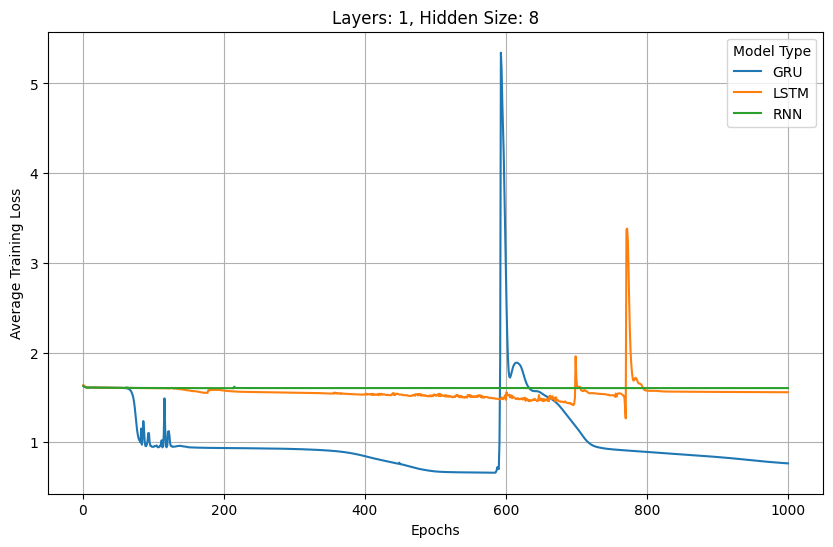

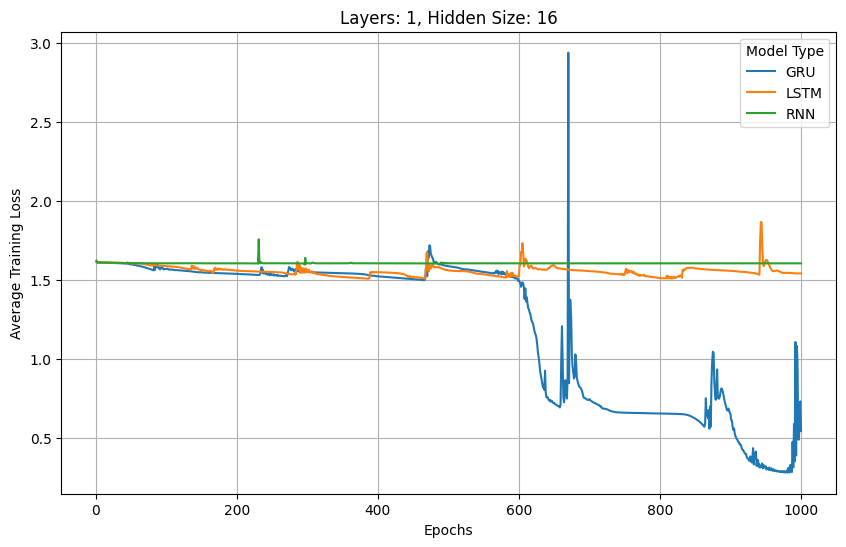

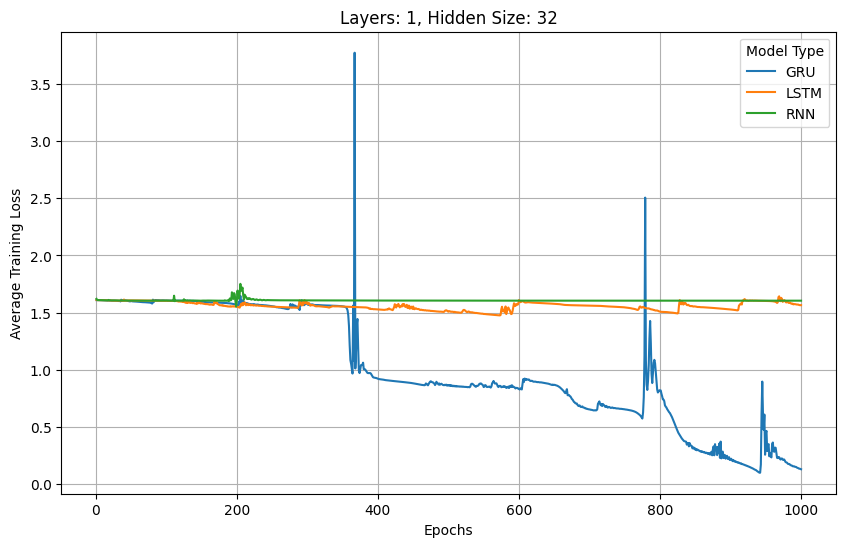

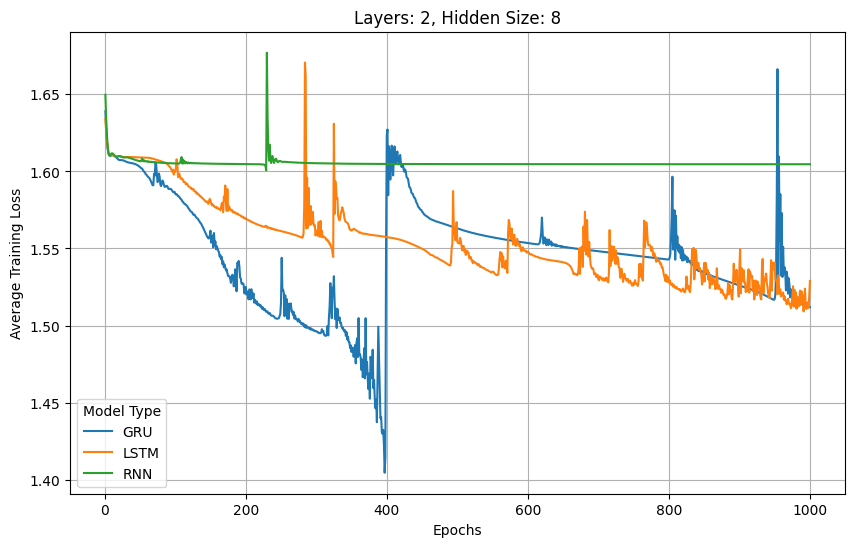

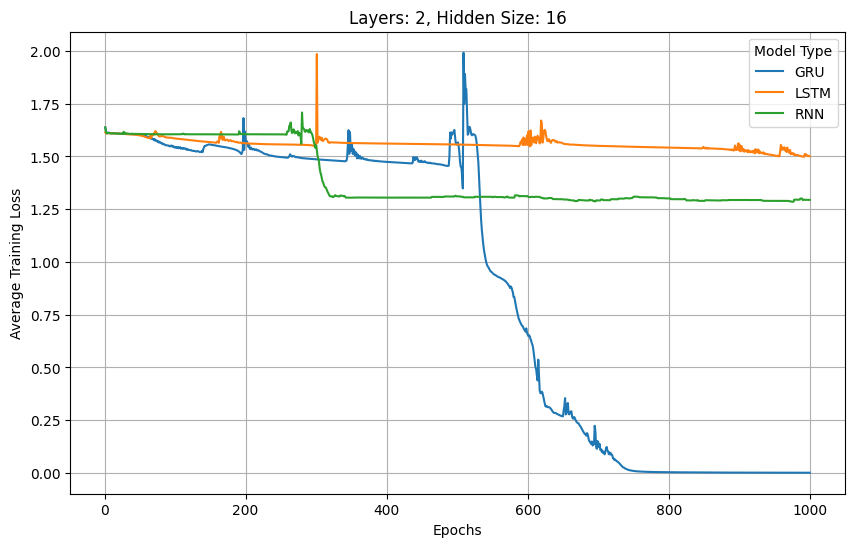

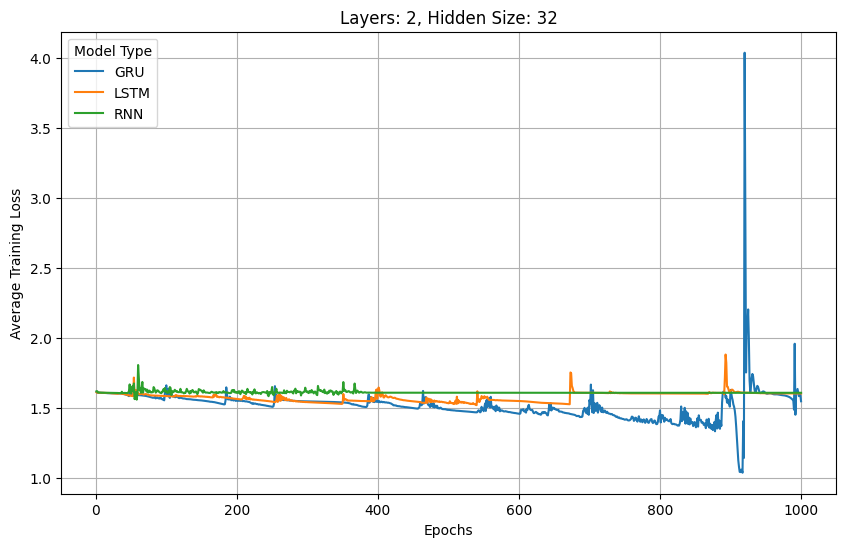

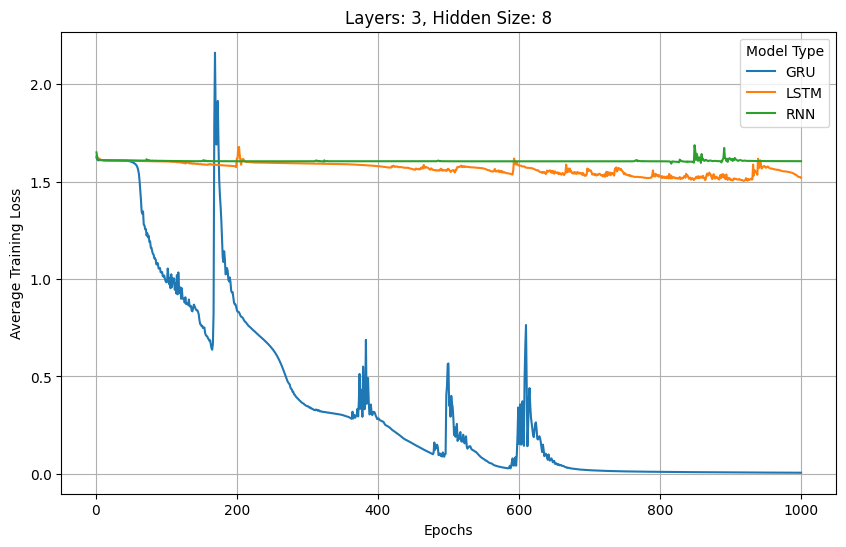

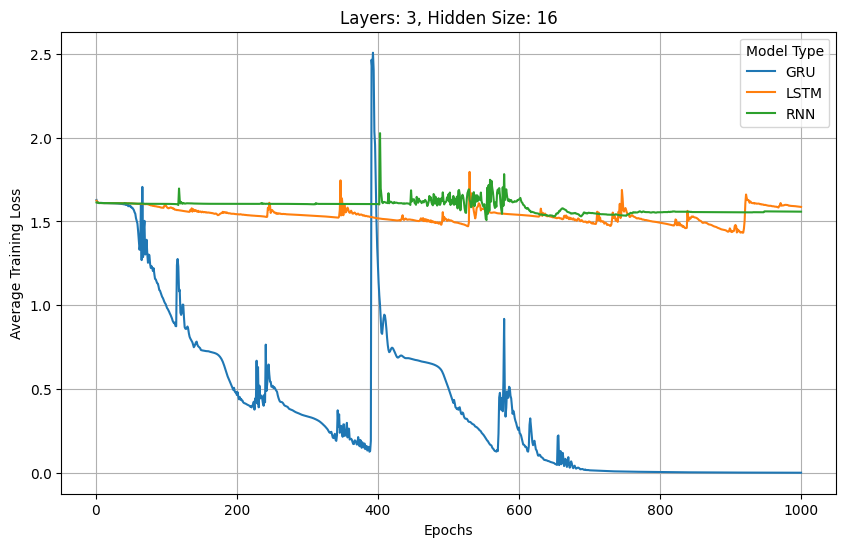

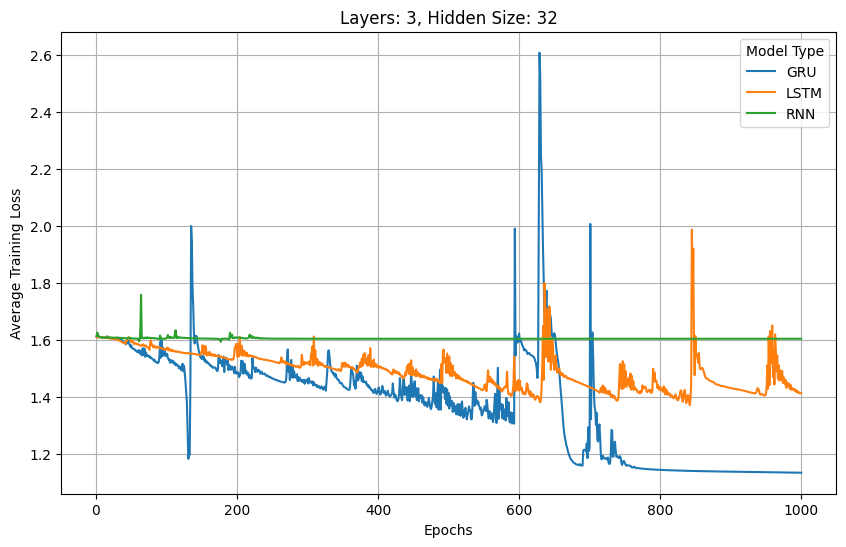

In [161]:
import matplotlib.pyplot as plt

for (num_layers, hidden_size), group_data in Modtab.groupby(['Number of Layers', 'Hidden Size']):
    plt.figure(figsize=(10, 6))  # Create a new figure for each hyperparameter set
    plt.title(f'Layers: {num_layers}, Hidden Size: {hidden_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Average Training Loss')

    # Iterate over model types within each group of layers and hidden size
    for model_type, model_data in group_data.groupby('Type'):
        # Assuming 'Training Loss' column contains a list of losses
        losses = model_data['Training Loss'].iloc[0]
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, label=model_type)  # Plot with label as model type

    plt.legend(title='Model Type')  # Add legend for model types
    plt.grid(True)
    plt.show()  # Display the plot for the current layers and hidden size combination


In [162]:
# Find the row with the largest test accuracy
best_model_row = Modtab.loc[Modtab['Testing Accuracy'].idxmax()]

print("Best Model:")
print(best_model_row)

Best Model:
Type                                                               GRU
Hidden Size                                                          8
Number of Layers                                                     3
Training Loss        [1.624297857284546, 1.6145449876785278, 1.6104...
Training Accuracy                                                  1.0
Testing Accuracy                                                  0.99
Model                GRUModel(\n  (gru): GRU(2, 8, num_layers=3, ba...
Name: 24, dtype: object


## **Confusion Matrix for best model**

Test Accuracy of the best model: 0.99


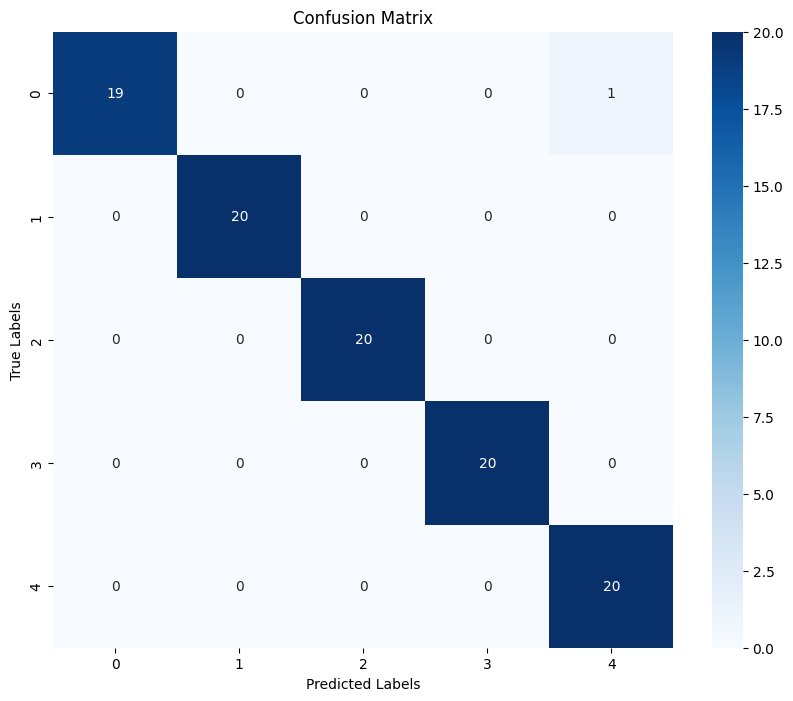

Training Accuracy of the best model: 1.0


In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'best_model_row' from the previous code contains the best model's information
best_model_type = best_model_row['Type']
best_hidden_size = int(best_model_row['Hidden Size'])
best_num_layers = int(best_model_row['Number of Layers'])
best_model = best_model_row['Model']

# Evaluate the best model on the test set
best_model.eval()
with torch.no_grad():
    outputs = best_model(handwriting_data_test_shuf)
    _, predicted = torch.max(outputs.data, 1)
    test_accuracy = (predicted == numeric_labels_test).sum().item() / numeric_labels_test.size(0)
    print(f"Test Accuracy of the best model: {test_accuracy}")

    # Get predicted labels for the test set
    predicted_labels = predicted.cpu().numpy()
    true_labels = numeric_labels_test.cpu().numpy()

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Training Accuracy
best_model.eval()
with torch.no_grad():
    outputs = best_model(handwriting_data)
    _, predicted = torch.max(outputs.data, 1)
    train_accuracy = (predicted == numeric_labels).sum().item() / numeric_labels.size(0)
    print(f"Training Accuracy of the best model: {train_accuracy}")

In [164]:
# Reverse the label mapping to get original names
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Get predictions for the first 10 test data points
best_model.eval()
with torch.no_grad():
    outputs = best_model(handwriting_data_test_shuf[:10])
    _, predicted_indices = torch.max(outputs.data, 1)

# Convert predicted indices back to original labels
predicted_labels = [idx_to_label[idx.item()] for idx in predicted_indices]

print("Predictions for the first 10 test data points:")
for i in range(10):
    print(f"Data point {i+1}: Predicted label - {predicted_labels[i]}, True Label - {handwriting_labels_test_shuf[i]}")

Predictions for the first 10 test data points:
Data point 1: Predicted label - bA, True Label - bA
Data point 2: Predicted label - chA, True Label - chA
Data point 3: Predicted label - ai, True Label - ai
Data point 4: Predicted label - chA, True Label - chA
Data point 5: Predicted label - a, True Label - a
Data point 6: Predicted label - ai, True Label - ai
Data point 7: Predicted label - chA, True Label - chA
Data point 8: Predicted label - ai, True Label - ai
Data point 9: Predicted label - bA, True Label - bA
Data point 10: Predicted label - dA, True Label - dA


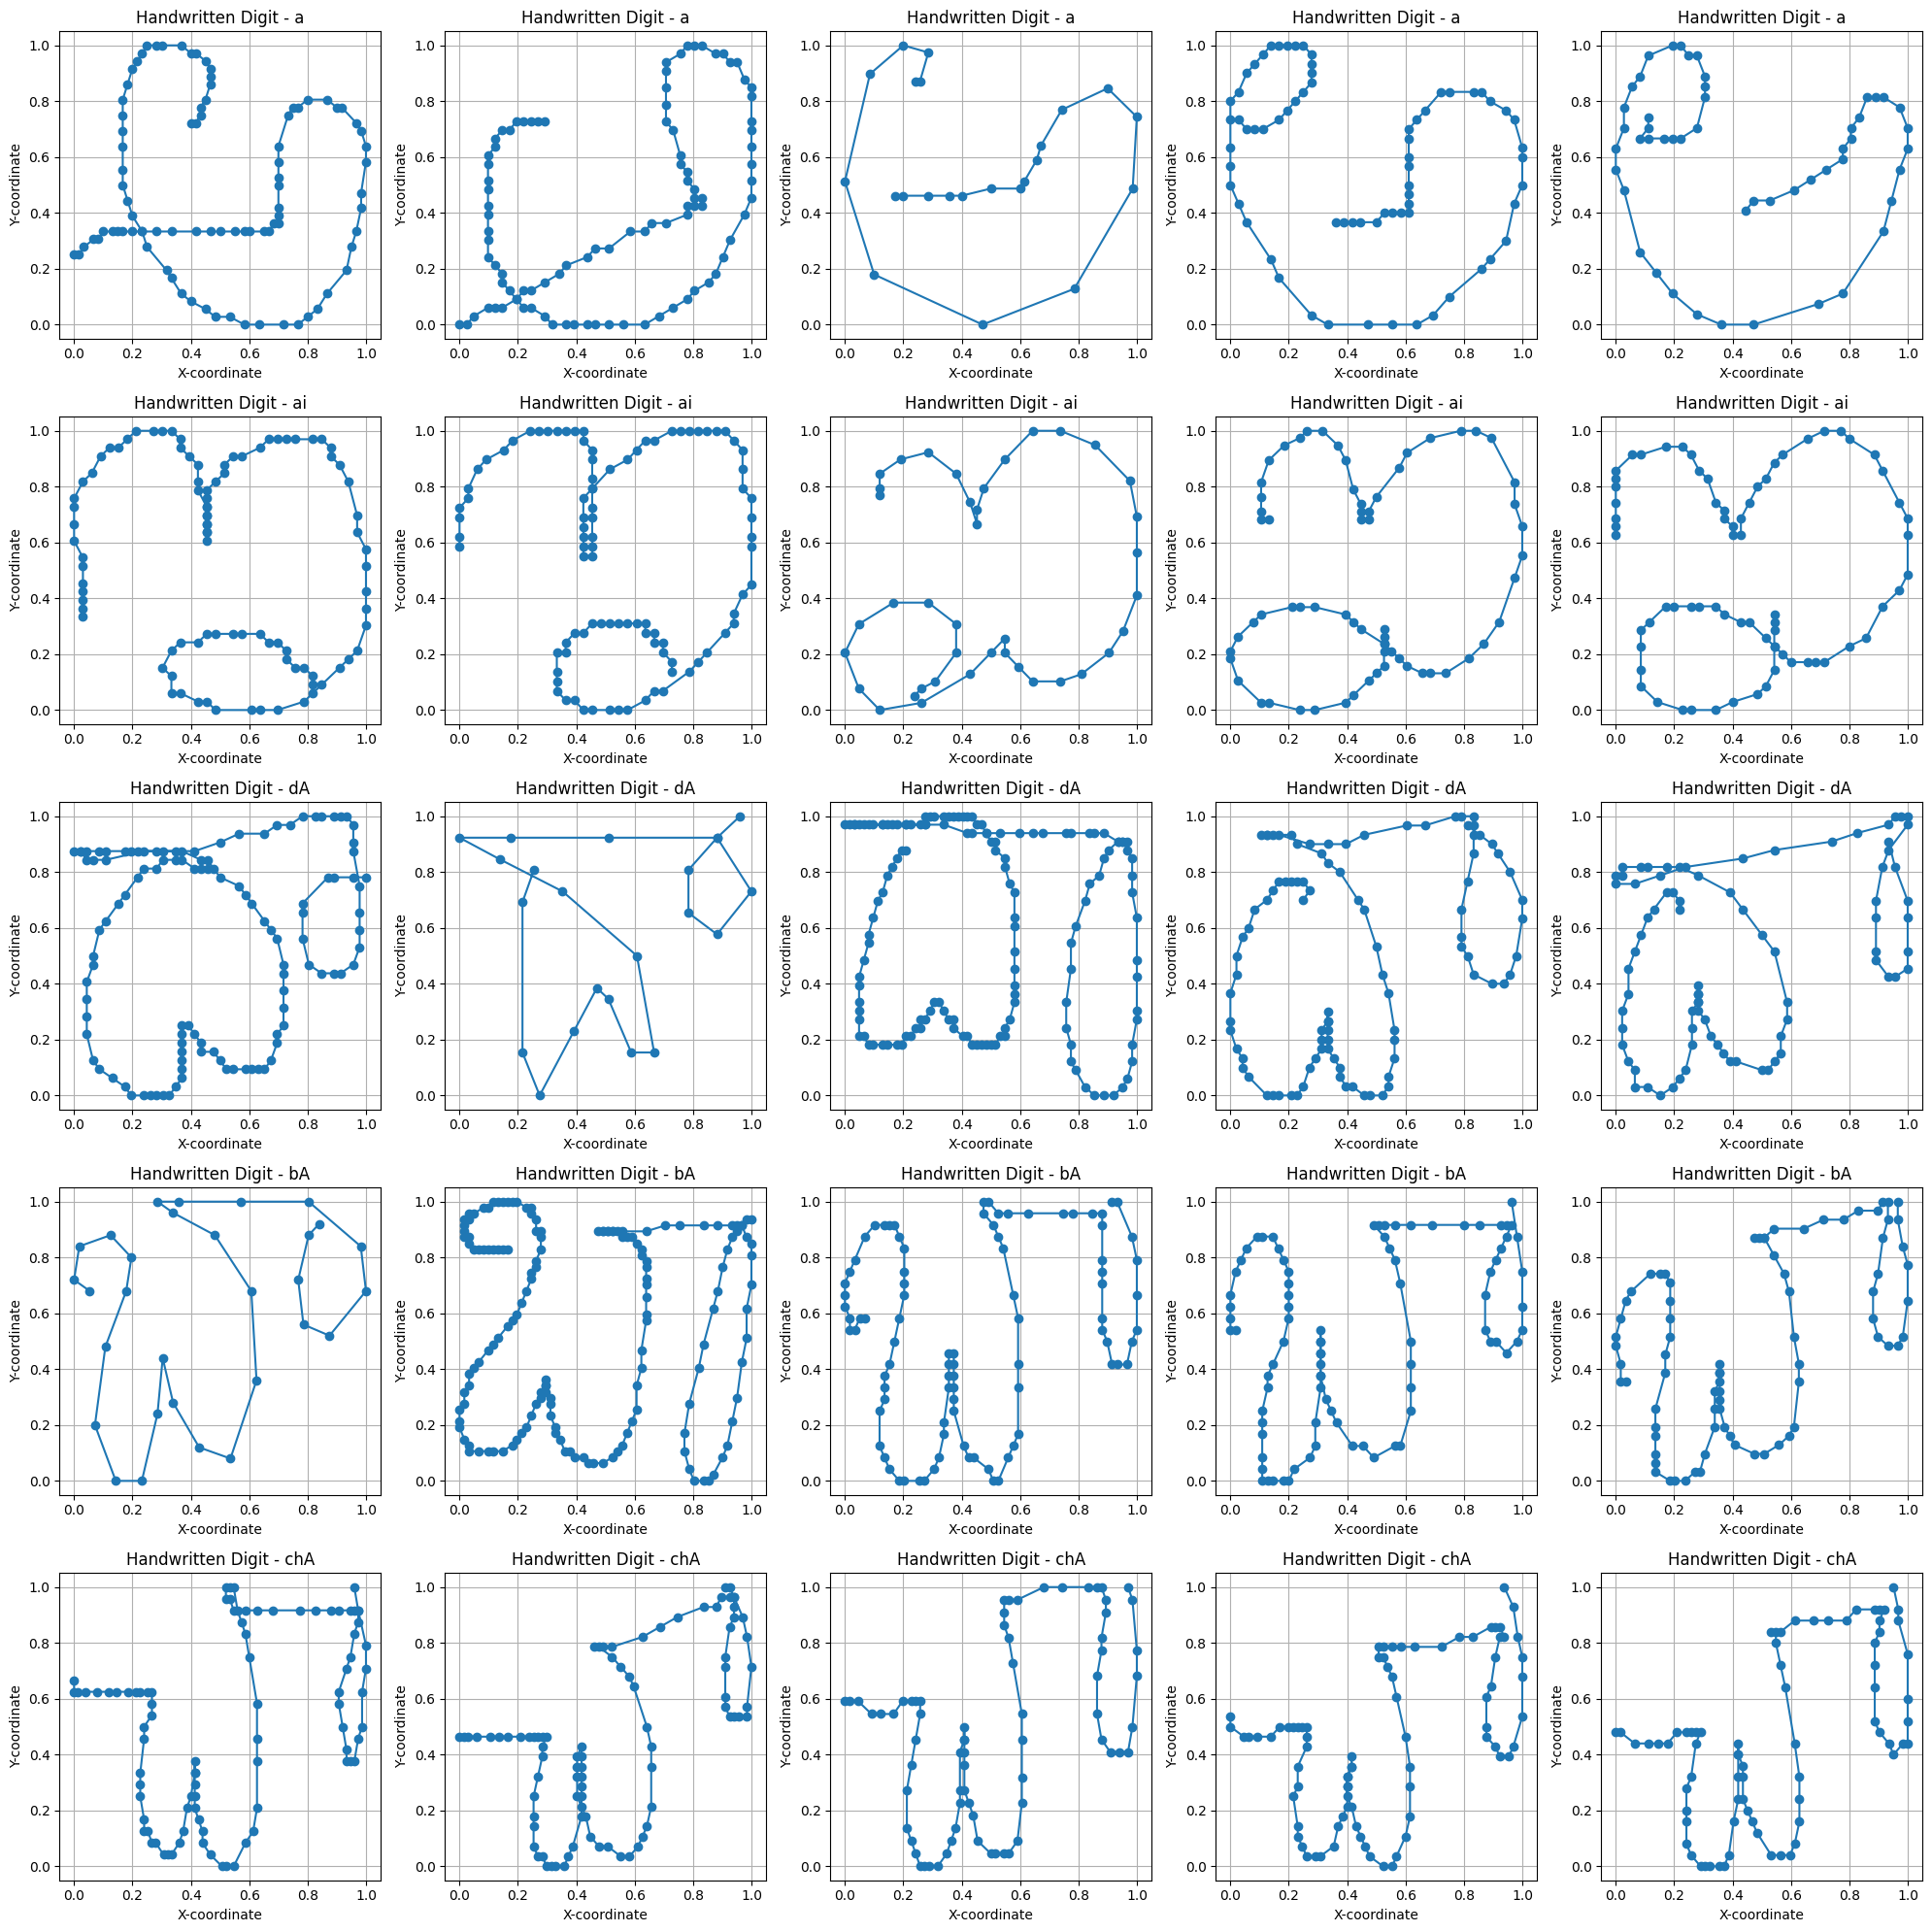

In [165]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # 2 rows, 5 columns

for row, i in enumerate([0, 69, 139, 209, 279]):
    for col in range(5):
        ax = axes[row, col]  # Access the subplot for this row and column
        data = handwriting_data_train[i+col]
        label = handwriting_labels_train[i+col]

        x_coords = data[:, 0]
        y_coords = data[:, 1]

        ax.plot(x_coords, y_coords, marker='o', linestyle='-')
        ax.set_title(f"Handwritten Digit - {label}")
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")
        ax.grid(True)


# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()